## Question 1

## 1.0 Prepare for the video dataset


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

In [548]:
from utils import check_range, has_nan

In [547]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/Users/binglunli/Desktop/IC_UROP/utils.py'>

In [89]:
total_size = 48
train_size = 40
test_size = 8
timesteps, height, width = 16, 128, 128
filename = 'fire_Chimney_video_'
num_img = 8

In [4]:
def read_video_to_array(video_path):
    
    video = cv2.VideoCapture(video_path)
    
    # Each video has exactly 16 frames of 128x128 pixels
    frames = np.zeros((timesteps, height, width), dtype=np.uint8)
    
    frame_count = 0
    success = True
    while success:
        success, frame = video.read()
        if success:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # resized_frame = cv2.resize(gray_frame, (128, 128))
            frames[frame_count] = gray_frame
            frame_count += 1
            
    video.release()
    assert frame_count == 16, "Number of Frames is inconsistent"
    
    return frames

In [5]:
def read_all_videos(input_folder, size=48):
    video_files = []
    for index in range(size):
        video_files.append(os.path.join(input_folder, filename + str(index) + '.mp4'))
    videos = []
    for video_path in tqdm.tqdm(sorted(video_files)):
        videos.append(read_video_to_array(video_path))
        
    return np.array(videos)

In [6]:
# Example usage
input_folder =  os.getcwd() + '/VIDEOS'
output_folder = os.getcwd() + 'FRAMES'
videos = read_all_videos(input_folder)

100%|██████████| 48/48 [00:00<00:00, 275.47it/s]


In [7]:
assert videos.shape == (48, 16, 128, 128), "Shape of dataset is incorrect!"
train_videos, test_videos = videos[:train_size], videos[train_size:train_size + test_size]
assert train_videos.shape == (train_size, 16, 128, 128), "Shape of dataset is incorrect!"
assert test_videos.shape == (test_size, 16, 128, 128), "Shape of dataset is incorrect!"

## 1.1 Perform the principle component analysis on the dataset

### 1.1.1 Apply PCA on the entire video dataset and evaluate the reconstruction error

In [8]:
from sklearn.decomposition import PCA

videos_reshaped = videos.reshape(total_size * timesteps, height * width)

pca = PCA(n_components=128) 
videos_compressed = pca.fit_transform(videos_reshaped)
videos_decompressed = pca.inverse_transform(videos_compressed)
videos_decompressed_reshaped = videos_decompressed.reshape(total_size, timesteps, height, width)

pca_recon_error = np.mean((videos - videos_decompressed_reshaped) ** 2) / total_size
round(pca_recon_error, 4)

1.0674

### 1.1.2 Plot the difference between the image before and after PCA compression

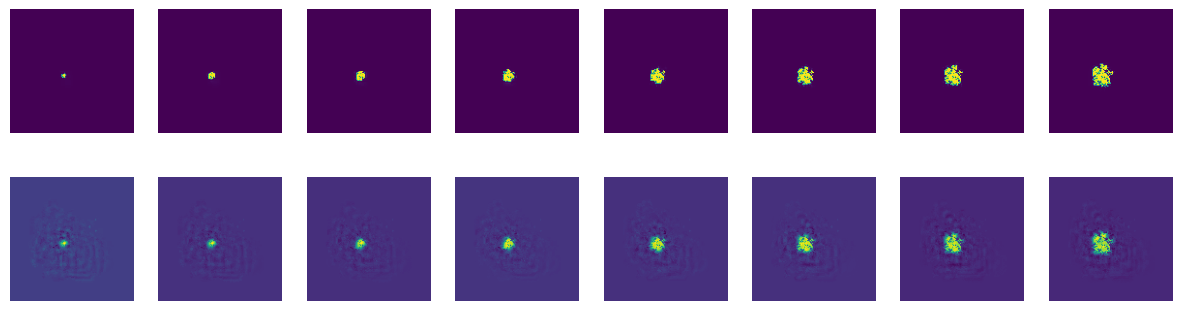

In [9]:
fig, ax = plt.subplots(2, num_img, figsize=(15, 4))
for i in range(num_img):
    ax[0, i].imshow(videos[0][i])
    ax[1, i].imshow(videos_decompressed_reshaped[0][i])
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')

The higher the number of PCA components, the more accurate the image reconstruction becomes. This indeed makes sense because reducing tensors to a lower dimension results in a greater loss of information, given that the PCA is not reversible.

## 1.2 Perform CAE(convolutional autoencoder) analysis

### 1.2.1 Prepare tensors for autoencoders

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

train_videos_tensor = torch.from_numpy(train_videos).float() # [40, 16, 128, 128]
test_videos_tensor = torch.from_numpy(test_videos).float() # [8, 16, 128, 128]

train_data, val_data = torch.split(train_videos_tensor, dim=0, split_size_or_sections=[32, 8]) 
test_data = test_videos_tensor.view(-1, 128, 128).unsqueeze(1) # [8*16, 1, 128, 128]
train_loader = torch.split(train_data, dim=1, split_size_or_sections=1) # 16 * 【32， 1， 128， 128】
val_loader = torch.split(val_data, dim=1, split_size_or_sections=1)     # 16 * 【8， 1， 128， 128】
test_loader = torch.split(test_data, dim=1, split_size_or_sections=1)   # 16 * 【8， 1， 128， 128】

In [111]:
for data in test_loader:
    print(data.shape)

torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


### 1.2.2 Define the convolutional autoencoder model

In [139]:
class ConvAutoencoderMaxpool(nn.Module):
    def __init__(self):
        super(ConvAutoencoderMaxpool, self).__init__()
    
        self.encoder = nn.Sequential(
            # 1 input channel due to grayscale images
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),   # [batch, 16, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # [batch, 16, 64, 64]
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # [batch, 32, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # [batch, 32, 32, 32]
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),  # [batch, 8, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # [batch, 1, 16, 16]
        )
    
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 32, 3, stride=2, padding=1, output_padding=1),  # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [batch, 16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # [batch, 1, 128, 128]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [140]:
class ConvAutoencoderDeep(nn.Module):
    def __init__(self):
        super(ConvAutoencoderDeep, self).__init__()

        self.encoder = nn.Sequential(
            # 1 input channel due to grayscale images
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # [batch, 16, 64, 64]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=2, padding=1),  # [batch, 1, 16, 16]
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 32, 3, stride=2, padding=1, output_padding=1),  # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [batch, 16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # [batch, 1, 128, 128]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            # 1 input channel due to grayscale images
            nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=1),  # [batch, 16, 64, 64]
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=1),  # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=1),  # [batch, 1, 16, 16]
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 1, 3, stride=2, padding=1, output_padding=1),  # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(1, 1, 3, stride=2, padding=1, output_padding=1),  # [batch, 16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(1, 1, 3, stride=2, padding=1, output_padding=1),  # [batch, 1, 128, 128]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### 1.2.3 Train the convolutional autoencoder on the video dataset

In [743]:
def train_cae(model): 
    num_epochs = 50
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    sigmoid = nn.Sigmoid()
    
    for epoch in range(num_epochs):
        for data in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, sigmoid(data))
            loss.backward()
            optimizer.step()
                
        if epoch % 5 == 0: 
            with torch.no_grad():
                val_loss = 0
                for data in val_loader:
                    output = model(data)
                    val_loss += criterion(output, sigmoid(data)).item()
                val_loss /= len(val_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')
    
    torch.save(model.state_dict(), os.getcwd() + f'/params/autoencoder_{val_loss:.4f}.pth')

In [108]:
autoencoder_maxpool = ConvAutoencoderMaxpool()
train_cae(autoencoder_maxpool)

Epoch [1/50], Loss: 0.0136, Val Loss: 0.0048
Epoch [6/50], Loss: 0.0035, Val Loss: 0.0015
Epoch [11/50], Loss: 0.0034, Val Loss: 0.0014
Epoch [16/50], Loss: 0.0033, Val Loss: 0.0013
Epoch [21/50], Loss: 0.0032, Val Loss: 0.0013
Epoch [26/50], Loss: 0.0031, Val Loss: 0.0013
Epoch [31/50], Loss: 0.0031, Val Loss: 0.0013
Epoch [36/50], Loss: 0.0030, Val Loss: 0.0012
Epoch [41/50], Loss: 0.0029, Val Loss: 0.0012
Epoch [46/50], Loss: 0.0028, Val Loss: 0.0012


In [112]:
autoencoder_deep = ConvAutoencoderDeep()
train_cae(autoencoder_deep)

Epoch [1/50], Loss: 0.0075, Val Loss: 0.0041
Epoch [6/50], Loss: 0.0034, Val Loss: 0.0015
Epoch [11/50], Loss: 0.0032, Val Loss: 0.0014
Epoch [16/50], Loss: 0.0032, Val Loss: 0.0014
Epoch [21/50], Loss: 0.0031, Val Loss: 0.0014
Epoch [26/50], Loss: 0.0031, Val Loss: 0.0014
Epoch [31/50], Loss: 0.0030, Val Loss: 0.0014
Epoch [36/50], Loss: 0.0030, Val Loss: 0.0014
Epoch [41/50], Loss: 0.0030, Val Loss: 0.0014
Epoch [46/50], Loss: 0.0031, Val Loss: 0.0014


### 1.2.4 Plot the difference between images before and after compression

Reconstruction loss (with maxpooling): 0.2314
Reconstruction loss : 0.2483


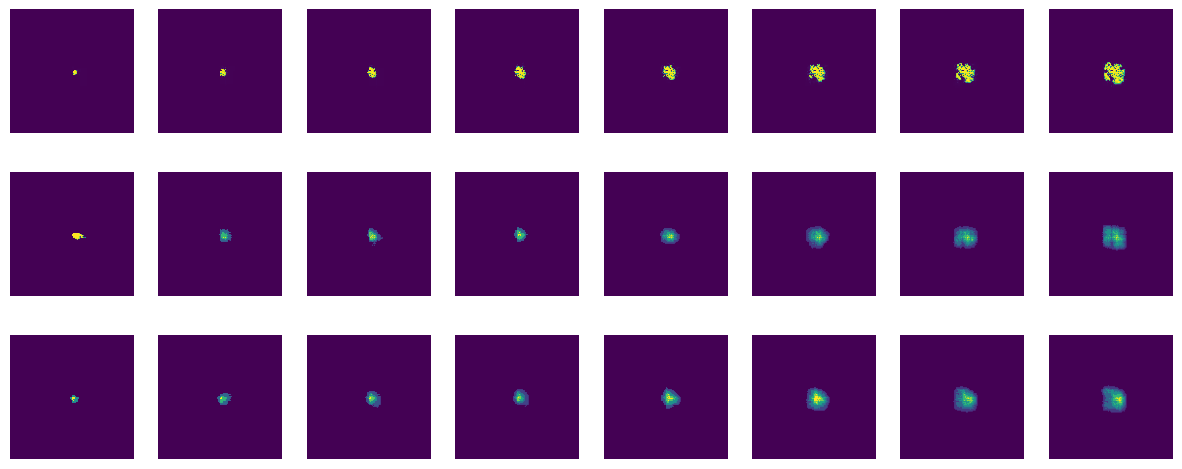

In [542]:
recon_maxpool = []
recon_deep = []
for data in test_data: 
    output = autoencoder_maxpool(data)  # [1, 128, 128]
    # use logit as the inverse of sigmoid
    greyscale_image = (torch.logit(output)).type(torch.uint8).squeeze(0).numpy()
    recon_maxpool.append(greyscale_image)
    
    output = autoencoder_deep(data)  # [1, 128, 128]
    # use logit as the inverse of sigmoid
    greyscale_image = (torch.logit(output)).type(torch.uint8).squeeze(0).numpy()
    recon_deep.append(greyscale_image)
    
cae_recon_error_maxpool = np.mean((np.array(recon_maxpool) - test_data.type(torch.uint8).squeeze(0).numpy()) ** 2) / test_size
cae_recon_error_deep = np.mean((np.array(recon_deep) - test_data.type(torch.uint8).squeeze(0).numpy()) ** 2) / test_size
print(f"Reconstruction loss (with maxpooling): {cae_recon_error_maxpool:.4f}")
print(f"Reconstruction loss : {cae_recon_error_deep:.4f}")

fig, ax = plt.subplots(3, num_img, figsize=(15, 6))
for i in range(num_img):
    ax[0, i].imshow(test_data[i].squeeze(0).numpy())
    ax[1, i].imshow(recon_maxpool[i])
    ax[2, i].imshow(recon_deep[i])
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')

# Question 2

### 2.1 Prepare the sequential encoded data for the seq2seq LSTM model

In [241]:
def create_seq_data(data_loader, autoencoder, batch_size):
    encoded_data = []
    seq_data = []
    for data in data_loader:
        encoded_batch = autoencoder.encoder(data)
        encoded_data.append(encoded_batch.view(batch_size, 1, -1))
    concat_data =  torch.cat(encoded_data, 1)
    print(concat_data.shape)
    for i in range(len(encoded_data) - 3):
        seq_data.append(concat_data[:, i:i+4, :])
        
    return seq_data

In [242]:
seq_train_data = create_seq_data(train_loader, autoencoder_deep, 32)   
seq_val_data = create_seq_data(val_loader, autoencoder_deep, 8)
print(seq_val_data[0].shape, len(seq_val_data))
# len(seq_train_data), seq_train_data[0].shape

torch.Size([32, 16, 256])
torch.Size([8, 16, 256])
torch.Size([8, 4, 256]) 13


### 2.2 Define the LSTM model

The seq2seq LSTM implemented here directly predicts the future 4 timesteps

In [243]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(Seq2SeqLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # PyTorch's nn.LSTM module handles the unrolling internally
        lstm_out, (hidden, cell) = self.lstm(x) # [batch_size, seq_length, hidden_dim]
        seq_out = self.fc(lstm_out)  # [batch_size, seq_length, output_dim]
        return seq_out

In [320]:
def train_lstm(model, criterion=nn.MSELoss()):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 100
    duplicate = seq_train_data.copy()
    
    for epoch in range(num_epochs):
        for index, inputs in enumerate(seq_train_data[:-1]):
            optimizer.zero_grad()
            outputs = model(inputs)     # inputs shape: [batch_size, seq_length, input_dim]
            # TODO: decide the stride of the target
            if criterion == SSIMLoss():
                loss = criterion(outputs.view(32, 4, 16, 16), duplicate[index + 1].view(32, 4, 16, 16))
            else:
                loss = criterion(outputs, duplicate[index + 1])
            loss.backward(retain_graph=True)
            optimizer.step()
            
        if epoch % 5 == 0: 
            with torch.no_grad():
                val_loss = 0
                for index, data in enumerate(seq_val_data[:-1]):
                    output = model(data)
                    val_loss += criterion(output.view(8, 4, 16, 16), seq_val_data[index + 1].view(8, 4, 16, 16)).item()
                val_loss /= len(val_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

### 2.3 Define different loss metrics

In [245]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, predicted, actual):
        return torch.sqrt(self.mse(predicted, actual))

In [317]:
import torch
import torch.nn.functional as F
from math import exp

# Implementation of Structural Similarity Index (SSIM) in PyTorch
class SSIMLoss(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = self.create_window(window_size, self.channel)

    def create_window(self, window_size, channel):
        def gaussian(window_size, sigma):
            gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
            return gauss / gauss.sum()

        _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = self.create_window(self.window_size, channel)
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            self.window = window
            self.channel = channel

        mu1 = F.conv2d(img1, window, padding=self.window_size // 2, groups=channel)
        mu2 = F.conv2d(img2, window, padding=self.window_size // 2, groups=channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding=self.window_size // 2, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding=self.window_size // 2, groups=channel) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding=self.window_size // 2, groups=channel) - mu1_mu2

        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

        if self.size_average:
            return 1 - ssim_map.mean()
        else:
            return 1 - ssim_map.mean(1).mean(1).mean(1)

In [318]:
input_dim = 256  # Reduced to 16 * 16 by CAE
hidden_dim = 128  
num_layers = 2  
output_dim = 256 

lstm_ssim = Seq2SeqLSTM(input_dim, hidden_dim, num_layers, output_dim)
train_lstm(lstm_ssim, criterion=SSIMLoss())

Epoch [1/100], Loss: 0.8340, Val Loss: 0.5815
Epoch [6/100], Loss: 0.7452, Val Loss: 0.4732
Epoch [11/100], Loss: 0.7440, Val Loss: 0.4703
Epoch [16/100], Loss: 0.7429, Val Loss: 0.4669
Epoch [21/100], Loss: 0.7416, Val Loss: 0.4655
Epoch [26/100], Loss: 0.7400, Val Loss: 0.4666
Epoch [31/100], Loss: 0.7323, Val Loss: 0.4678
Epoch [36/100], Loss: 0.7075, Val Loss: 0.4609
Epoch [41/100], Loss: 0.6780, Val Loss: 0.4497
Epoch [46/100], Loss: 0.6573, Val Loss: 0.4523
Epoch [51/100], Loss: 0.6431, Val Loss: 0.4531
Epoch [56/100], Loss: 0.6365, Val Loss: 0.4588
Epoch [61/100], Loss: 0.6240, Val Loss: 0.4603
Epoch [66/100], Loss: 0.6095, Val Loss: 0.4620
Epoch [71/100], Loss: 0.6064, Val Loss: 0.4635
Epoch [76/100], Loss: 0.5900, Val Loss: 0.4601
Epoch [81/100], Loss: 0.5857, Val Loss: 0.4594
Epoch [86/100], Loss: 0.5739, Val Loss: 0.4586
Epoch [91/100], Loss: 0.5586, Val Loss: 0.4587
Epoch [96/100], Loss: 0.5571, Val Loss: 0.4606


In [247]:
lstm_rmse = Seq2SeqLSTM(input_dim, hidden_dim, num_layers, output_dim)
train_lstm(lstm_rmse, criterion=RMSELoss())

Epoch [1/100], Loss: 11.4170, Val Loss: 4.9682
Epoch [6/100], Loss: 9.8673, Val Loss: 4.3796
Epoch [11/100], Loss: 9.0110, Val Loss: 4.1082
Epoch [16/100], Loss: 8.3472, Val Loss: 3.9572
Epoch [21/100], Loss: 7.8031, Val Loss: 3.8458
Epoch [26/100], Loss: 7.3413, Val Loss: 3.7645
Epoch [31/100], Loss: 6.9397, Val Loss: 3.6821
Epoch [36/100], Loss: 6.5883, Val Loss: 3.6279
Epoch [41/100], Loss: 6.2819, Val Loss: 3.6210
Epoch [46/100], Loss: 6.0140, Val Loss: 3.5023
Epoch [51/100], Loss: 5.7743, Val Loss: 3.5119
Epoch [56/100], Loss: 5.5661, Val Loss: 3.4409
Epoch [61/100], Loss: 5.3808, Val Loss: 3.4010
Epoch [66/100], Loss: 5.2165, Val Loss: 3.2817
Epoch [71/100], Loss: 5.0629, Val Loss: 3.3193
Epoch [76/100], Loss: 4.9317, Val Loss: 3.2684
Epoch [81/100], Loss: 4.8008, Val Loss: 3.2588
Epoch [86/100], Loss: 4.6820, Val Loss: 3.2353
Epoch [91/100], Loss: 4.5739, Val Loss: 3.2020
Epoch [96/100], Loss: 4.4673, Val Loss: 3.1457


In [289]:
lstm_mse = Seq2SeqLSTM(input_dim, hidden_dim, num_layers, output_dim)
train_lstm(lstm_mse, criterion=nn.MSELoss())

Epoch [1/100], Loss: 130.2176, Val Loss: 36.7813
Epoch [6/100], Loss: 97.9556, Val Loss: 28.5289
Epoch [11/100], Loss: 80.9870, Val Loss: 24.8117
Epoch [16/100], Loss: 69.8772, Val Loss: 22.8217
Epoch [21/100], Loss: 61.5612, Val Loss: 21.2856
Epoch [26/100], Loss: 55.0659, Val Loss: 20.6526
Epoch [31/100], Loss: 49.8833, Val Loss: 19.8170
Epoch [36/100], Loss: 45.5837, Val Loss: 19.1402
Epoch [41/100], Loss: 42.0002, Val Loss: 18.6617
Epoch [46/100], Loss: 38.9613, Val Loss: 18.1886
Epoch [51/100], Loss: 36.3650, Val Loss: 17.8858
Epoch [56/100], Loss: 34.0666, Val Loss: 17.4940
Epoch [61/100], Loss: 32.0271, Val Loss: 17.2138
Epoch [66/100], Loss: 30.2866, Val Loss: 16.7509
Epoch [71/100], Loss: 28.6516, Val Loss: 16.6645
Epoch [76/100], Loss: 27.2287, Val Loss: 16.4384
Epoch [81/100], Loss: 25.9446, Val Loss: 16.1427
Epoch [86/100], Loss: 24.7644, Val Loss: 15.3070
Epoch [91/100], Loss: 23.6993, Val Loss: 15.0492
Epoch [96/100], Loss: 22.6880, Val Loss: 15.0357


### 2.4 Evaluate seq2seq LSTM model

In [248]:
seq_test_data = create_seq_data(test_data, autoencoder_deep, 1)

torch.Size([1, 128, 256])


In [286]:
def plot_predicted_image(index, model):
    recon_lstm = []
    output = model(seq_test_data[index]) # output shape: [1, 4, 256]
    four_timesteps = torch.split(output, dim=1, split_size_or_sections=1) # timestep shape: [1, 1, 256]
    for timestep in four_timesteps: 
        timestep = timestep.view(1, 1, 16, 16) # timestep shape: [1, 1, 16, 16]
        decoded_output = autoencoder_deep.decoder(timestep) # decoded_output [1, 1, 128, 128]
        greyscale_image = (torch.logit(decoded_output)).type(torch.uint8).squeeze(0, 1).numpy() # shape [128, 128]
        recon_lstm.append(greyscale_image)
       
    recon_error_lstm = 0
    for i in range(4):
        recon_error_lstm += np.mean((test_data[index + i + 1].type(torch.uint8).squeeze(0).numpy() - recon_lstm[i])**2)
    print(f"Average LSTM prediction & reconstruction loss: {recon_error_lstm / 4:.4f}")
    fig, ax = plt.subplots(2, 5, figsize=(11, 4))
    for i in range(5):
        ax[0, i].imshow(test_data[i + index].squeeze(0).numpy())
        if i < 4: 
            ax[1, i + 1].imshow(recon_lstm[i])
        ax[0, i].axis('OFF')
        ax[1, i].axis('OFF')

Average LSTM prediction & reconstruction loss: 0.8454


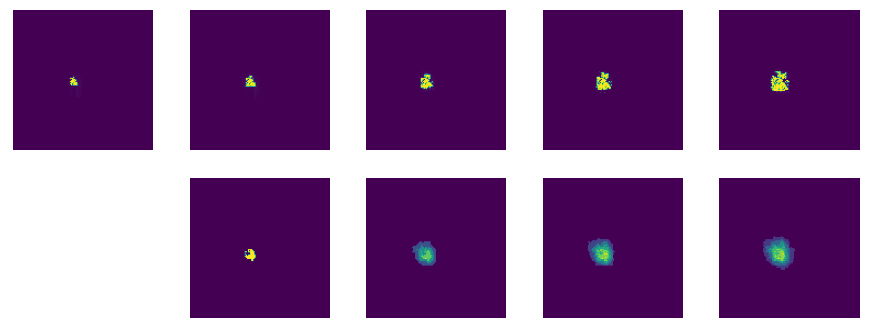

In [294]:
plot_predicted_image(81, lstm_rmse)

Average LSTM prediction & reconstruction loss: 0.8100


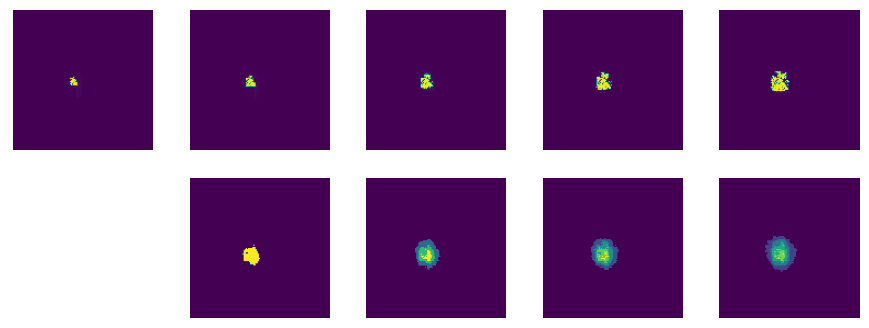

In [293]:
plot_predicted_image(81, lstm_mse)

Average LSTM prediction & reconstruction loss: 0.7739


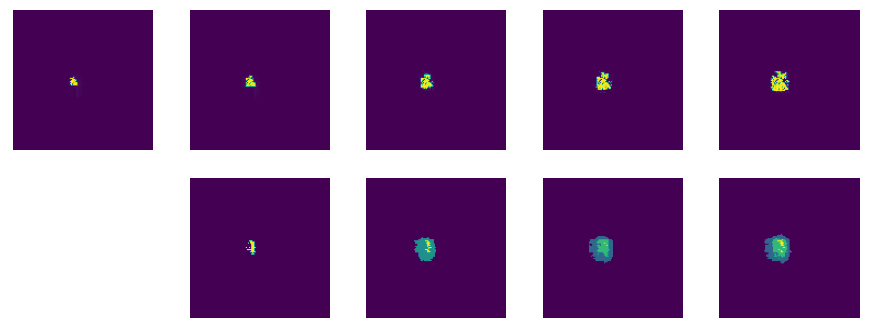

In [319]:
plot_predicted_image(81, lstm_ssim)

# Question 3

## 3.1 Sequence to Frame ConvLSTM model

**This ConvLSTM model only predicts the next frame based on the previous 4 frames**

In [887]:
class ConvLSTMCell(nn.Module):
 
    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):
 
        super(ConvLSTMCell, self).__init__()  
 
        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
         
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           
 
        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))
 
    def forward(self, X, H_prev, C_prev):
 
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))
        
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)
 
        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )
 
        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)
 
        output_gate = torch.sigmoid(o_conv + self.W_co * C )
 
        # Current Hidden State
        H = output_gate * self.activation(C)
        
        if has_nan(conv_output):
            raise ValueError('Nan Value Error')
 
        return H, C

In [872]:
class ConvLSTM(nn.Module):
 
    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):
 
        super(ConvLSTM, self).__init__()
 
        self.out_channels = out_channels
 
        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)
 
    def forward(self, X):
 
        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)
 
        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()
 
        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width)
         
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width)
 
        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width)
 
        # Unroll over time steps
        for time_step in range(seq_len):
            
            H, C = self.convLSTMcell(X[:,:,time_step], H, C)
            
            output[:,:,time_step] = H
 
        return output

In [873]:
class Seq2Frame(nn.Module):
 
    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers):
 
        super(Seq2Frame, self).__init__()
 
        self.sequential = nn.Sequential()
 
        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )
 
        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 
 
        # Add rest of the layers
        for l in range(2, num_layers+1):
 
            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )
                 
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 
 
        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)
 
    def forward(self, X):
 
        # Forward propagation through all the layers
        output = self.sequential(X)
 
        # Return only the last output frame
        output = self.conv(output[:,:,-1])
         
        return nn.Sigmoid()(output)

### 3.1.1 Prepare inputs for the ConvLSTM model

In [864]:
import random
def generate_seq2seq_dataset(raw_data, required_size, input_len=4, targat_len=1):
    """
    :param raw_data: data has shape [32, 16, 128, 128]
    :return: input_seq, target_seq
    """ 
    raw_data = raw_data / 255.0 # make all entries binary
    batch_size, total_len, height, width = raw_data.size()
    max_start_index = total_len - input_len - targat_len
    data_loader = []
    for _ in range(required_size):
        start_frame = random.randint(0, max_start_index)
        end_frame = start_frame + input_len
        input_seq = raw_data[:, start_frame:end_frame]
        target_seq = raw_data[:, end_frame:end_frame + targat_len]  
        data_loader.append((input_seq.unsqueeze(1), target_seq))
        
    return data_loader

In [865]:
# Required inputs shape: [batch_size, num_channels, seq_len, height, width]
# current train data: [32, 16, 128, 128]    required train data: [32, 1, 4, 128, 128]
train_dataloader_s2f = generate_seq2seq_dataset(train_data, 20, input_len=4, targat_len=1)
val_dataloader_s2f = generate_seq2seq_dataset(val_data, 5, input_len=4, targat_len=1)
# input seq shape: [batch_size, 4, 1, 128, 128], target seq shape: [batch_size, 4, 1, 128, 128]
print(len(train_dataloader_s2f))
for input, target in train_dataloader_s2f: 
    print(input.shape, target.shape)
    break

20
torch.Size([32, 1, 4, 128, 128]) torch.Size([32, 1, 128, 128])


### 3.1.2 Train the Seq2Frame ConvLSTM model on train data

In [866]:
def train_convlstm(model, train_dataloader, val_dataloader, num_epochs=20):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCELoss()
    
    for epoch in range(num_epochs):
        for input_seq, target_seq in train_dataloader: 
            optimizer.zero_grad()
            out_seq = model(input_seq)
            if out_seq.flatten().shape != target_seq.flatten().shape:
                print(out_seq.shape, target_seq.shape)
                raise ValueError('Output/Target Shape Error')    
            if has_nan(out_seq):
                raise ValueError('Nan Value Error')
            loss = criterion(out_seq.flatten(), target_seq.flatten())         # out_seq shape [batch_size, 1, 128, 128]
            loss.backward()
            optimizer.step()
            
        if epoch % 5 == 0: 
            with torch.no_grad():
                val_loss = 0
                for input_seq, target_seq in val_dataloader:
                    output_seq = model(input_seq)
                    val_loss += criterion(output_seq.flatten(), target_seq.flatten())
                val_loss /= len(val_dataloader)
                
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

In [888]:
conv_lstm_s2f = Seq2Frame(num_channels=1, num_kernels=4, kernel_size=(3, 3), padding=(1, 1), activation='relu', frame_size=(128, 128), num_layers=2)

In [889]:
train_convlstm(conv_lstm_s2f, train_dataloader_s2f, val_dataloader_s2f, 30)

Epoch [1/30], Loss: 0.5874, Val Loss: 0.6550
Epoch [6/30], Loss: 0.3215, Val Loss: 0.3396
Epoch [11/30], Loss: 0.2028, Val Loss: 0.2155
Epoch [16/30], Loss: 0.1415, Val Loss: 0.1554
Epoch [21/30], Loss: 0.1039, Val Loss: 0.1164
Epoch [26/30], Loss: 0.0786, Val Loss: 0.0893


### 3.1.3 Test the Seq2Frame ConvLSTM model on test data

In [893]:
# require shape: [1, 1, 4, 128, 128], test data shape [8, 16, 128, 128]
randint = random.randint(0, 7)
test_dataloader_s2f = generate_seq2seq_dataset(test_videos_tensor[randint:randint+1], 3, input_len=4, targat_len=1)

In [894]:
def plot_predicted_images_convlstm(model, test_dataloader, input_len, target_len):
    for test_input, test_target in test_dataloader:
        fig, ax = plt.subplots(2, input_len + target_len, figsize=(11, 4))
        test_output = model(test_input)  # test output shape [1, 1, 128, 128]
        inputs = torch.split(test_input, dim=2, split_size_or_sections=1) # 4 * [1, 1, 1, 128, 128]
        for index, frame in enumerate(inputs): 
            ax[0, index].imshow(((frame > 0.5)*255).squeeze(0, 1, 2).numpy())
        
        # print(test_target.shape, test_output.shape)
        targets = torch.split(test_target, dim=1, split_size_or_sections=1)
        if target_len == 1: 
            dim = 1
        else:
            dim = 2
        outputs = torch.split(test_output, dim=dim, split_size_or_sections=1)
        for index in range(target_len):
            ax[0, input_len + index].imshow(((targets[index] > 0.5)*255).squeeze(0, 1).numpy())
            ax[1, input_len + index].imshow(((outputs[index] > 0.5)*255).squeeze(0, 1, 2).numpy())
        
        for i in range(input_len + target_len):
            ax[0, i].axis('OFF')
            ax[1, i].axis('OFF')

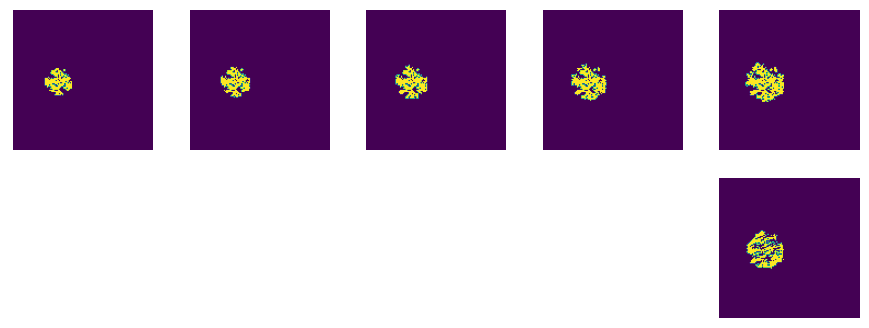

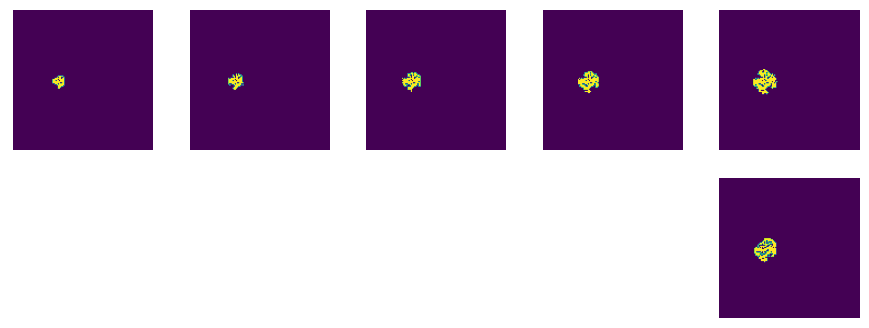

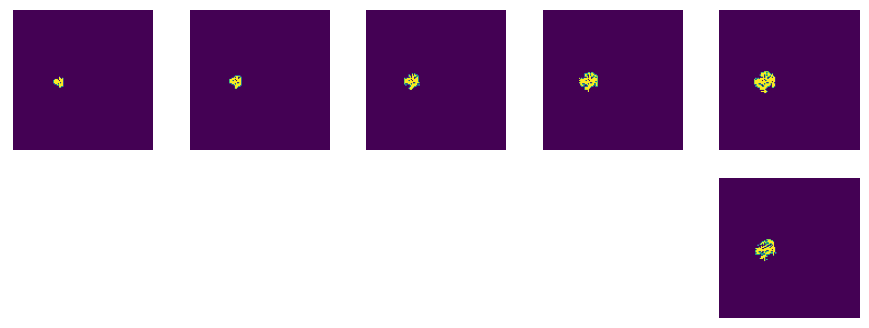

In [895]:
plot_predicted_images_convlstm(conv_lstm_s2f, test_dataloader_s2f, 4, 1)

## 3.2 Sequence to Sequence ConvLSTM model

In [830]:
class ConvLSTMS2S(nn.Module):
 
    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):
 
        super(ConvLSTMS2S, self).__init__()
 
        self.out_channels = out_channels
 
        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)
        
        self.conv_layer = nn.Conv2d(
            in_channels=4, out_channels=1,
            kernel_size=kernel_size, padding=padding)
        
        self.future_seq = 4
 
    def forward(self, X):
 
        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)
 
        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()
 
        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width)
        
        predict = torch.zeros(batch_size, 1, self.future_seq, 
        height, width)
         
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width)
 
        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width)
 
        # Unroll over time steps
        for time_step in range(seq_len):
            
            H, C = self.convLSTMcell(X[:,:,time_step], H, C)
            
            output[:,:,time_step] = H
            
        # Initialize the Predicted Frame 
        predict[:, :, 0] = self.conv_layer(output[:, :, -1])
            
        for time_step in range(self.future_seq - 1):
            H, C = self.convLSTMcell(predict[:,:,time_step], H, C)
            predict[:,:,time_step+1] = self.conv_layer(H)
 
        return predict

In [831]:
class Seq2Seq(nn.Module):
 
    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers):
 
        super(Seq2Seq, self).__init__()
 
        self.sequential = nn.Sequential()
        
        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)
 
        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTMS2S(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )
 
        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_channels)
        ) 
 
        # Add rest of the layers
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTMS2S(
                    in_channels=num_channels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )

            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_channels)
                ) 
 
 
    def forward(self, X):
 
        # Forward propagation through all the layers
        predict = self.sequential(X)
         
        return nn.Sigmoid()(predict.squeeze(1))

### 3.2.1 Train the Seq2seq ConvLSTM model 

In [814]:
train_dataloader_s2s = generate_seq2seq_dataset(train_data, 20, input_len=4, targat_len=4)
val_dataloader_s2s = generate_seq2seq_dataset(val_data, 5, input_len=4, targat_len=4)
print(len(train_dataloader_s2s))
for input, target in train_dataloader_s2s: 
    print(input.shape, target.shape)
    break

20
torch.Size([32, 1, 4, 128, 128]) torch.Size([32, 4, 128, 128])


In [832]:
conv_lstm_s2s = Seq2Seq(num_channels=1, num_kernels=4, kernel_size=(3, 3), padding=(1, 1), activation='relu', frame_size=(128, 128), num_layers=1)

In [833]:
train_convlstm(conv_lstm_s2s, train_dataloader_s2s, val_dataloader_s2s, num_epochs=50)

Epoch [1/50], Loss: 0.6380, Val Loss: 0.6521
Epoch [6/50], Loss: 0.6255, Val Loss: 0.6399
Epoch [11/50], Loss: 0.6164, Val Loss: 0.6305
Epoch [16/50], Loss: 0.6093, Val Loss: 0.6234
Epoch [21/50], Loss: 0.6018, Val Loss: 0.6161
Epoch [26/50], Loss: 0.5931, Val Loss: 0.6080
Epoch [31/50], Loss: 0.5860, Val Loss: 0.6015
Epoch [36/50], Loss: 0.5795, Val Loss: 0.5953
Epoch [41/50], Loss: 0.5734, Val Loss: 0.5895
Epoch [46/50], Loss: 0.5674, Val Loss: 0.5838


### 3.2.2 Test Seq2seq ConvLSTM model 

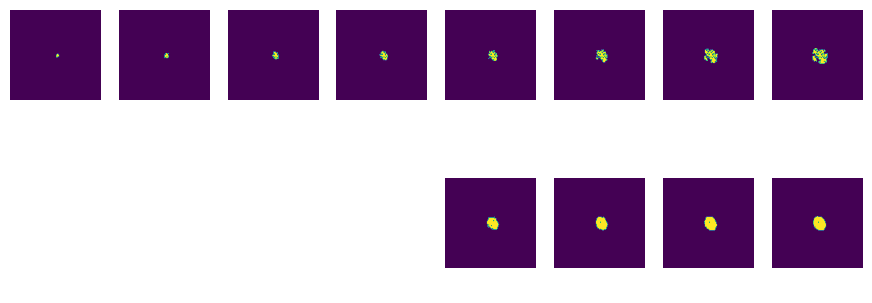

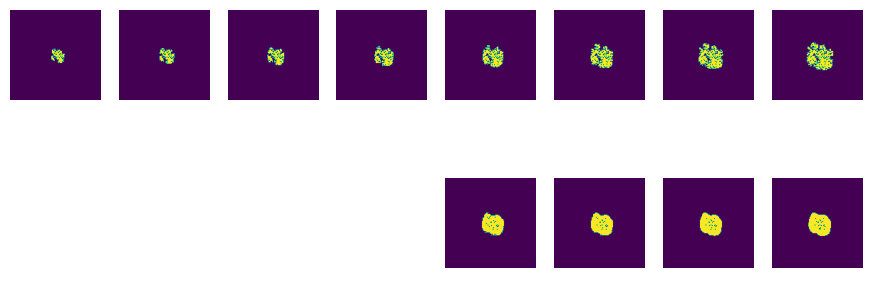

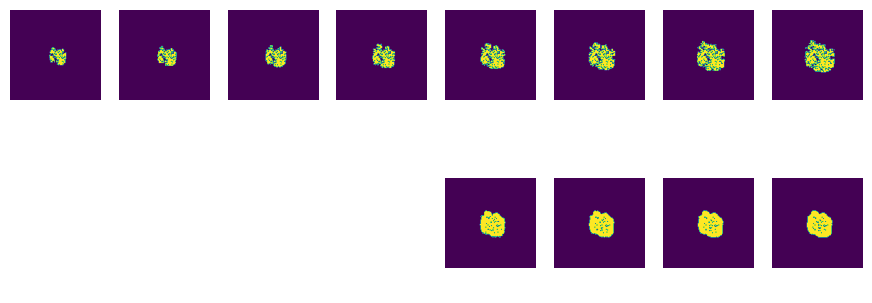

In [898]:
test_dataloader_s2s = generate_seq2seq_dataset(test_videos_tensor[0:1], 3, input_len=4, targat_len=4)
plot_predicted_images_convlstm(conv_lstm_s2s, test_dataloader_s2s, 4, 4)

## 3.3 Discussion: compare and contrast CAE + LSTM and ConvLSTM

For video prediction task, the CAE + LSTM approach initially encodes a sequence of frames, and this process reduces the images' dimensions to a more manageable size while extracting key features. Specifically, frames with the original shape of (1, 128, 128) [num_channels, height, width] are encoded down to (1, 16, 16). These encoded frames are then flattened into tensors of size (1, 256) to match the input size of the LSTM network (which models the sequence and predicts future frames). 

As indicated by the accuracy and visualised plots, the effectiveness of the CAE + LSTM model I built is limited. I believe this is due to several factors. In terms of implementation, the currently employed compression and encoding process might not be the optimal solution, so that the overall performance of the CAE + LSTM model is compromised. Further optimisations on implementation are possible. With respect to the model architecture, the LSTM operates on a lower-dimensional latent space and may lose some spatial details that are critical for accurate frame prediction. In addition, flattening might also lead to spatial information lose. The only advantages of this architecture I believe is that it is much flexible than others -- one can employ alternative encoder/decoder models for compression, especially pre-trained models. 

ConvLSTM made some improvements on the traditional FC-LSTM, which lacks the encoding of spatial information (while it contains good temporal information encoding). To overcome this problem, it modifies the architecture such that the Input Cells, Cell outputs, and Hidden states are all embedded in 3D tensors rather than 2D, with the last 2 dimension storing spatial information (and the first dimension still retain the temporal info). It also adds a Convolution layer to the tensors of Input Cells and Hidden states. So now, hidden states contain both temporal and spacial information, and the model would be better to capture and learn the patterns in the input space. 

I did two experiments on ConvLSTM. The first one only predicts the next single frame, and the second predicts the next four frames, given the previous four frames. As shown by the plot and data. The former has a higher converging rate of loss, indicating that it's easier to learn the next single frame. 


# 4. Knowing that the field (i.e., the white area) can only be increasing. How this information can be used to enhance your model prediction?

- Firstly, knowing that the field can only be increasing, I can customise the loss function such that it would encourage overestimates of field and penalise underestimates of the field by given different weights. This would help the model capture the trend of videos faster, since the gradient is more likely to point to the increasing direction. 
- Attention mechanism can be used here: when doing spacial and temporal encoding, attention mechanism allows the model to read the entire sequence in one shot, so that the model would be able to capture the increasing trend along the temporal space. More importantly, the model with attention would be capable to learn to focus on the future trend. This is not only limited to increasing pattern, but many other patterns as well. 
- Pretraining can be used to enhance the performance -- I can design synthetic data with only strictly increasing field to let the model adapts this pattern. Then further training on real data would learn faster. 
- Naive idea: try to model and quantify the increasing area of fields along the temporal axis. So may be combined with some RL methods to create a reward signal based on the increase in the field area. Not familiar with RL, but I believe this technique can be incorporated. 